In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# random seed lang
np.random.seed(42)

def load_data():
    """
    Try to load Melbourne housing data from uploaded file
    """
    try:
        print("Trying to load Melbourne housing dataset...")
        import io
        data = window.fs.readFile('/csv/midterm_dataset/melb_data.csv', {'encoding': 'utf8'})
        df = pd.read_csv(io.StringIO(data))
        print(f"✅ Successfully loaded Melbourne housing dataset!")
        return df
    except Exception as e:
        print(f"Could not load file: {e}")
        print("Generating sample data instead...")
        np.random.seed(42)
        n_samples = 300
        
        suburbs = ['Abbotsford', 'Richmond', 'Hawthorn', 'Brunswick', 'Fitzroy']
        types = ['h', 'u', 't']
        methods = ['S', 'PI', 'VB', 'SP']
        sellers = ['Biggin', 'Nelson', 'Ray', 'Barry', 'Miles']
        councils = ['Yarra', 'Melbourne', 'Boroondara', 'Moreland']
        regions = ['Northern Metropolitan', 'Southern Metropolitan', 'Western Metropolitan', 'Eastern Metropolitan']
        
        df = pd.DataFrame({
            'Suburb': np.random.choice(suburbs, n_samples),
            'Rooms': np.random.randint(1, 6, n_samples),
            'Type': np.random.choice(types, n_samples),
            'Price': np.random.uniform(300000, 2000000, n_samples),
            'Method': np.random.choice(methods, n_samples),
            'SellerG': np.random.choice(sellers, n_samples),
            'Distance': np.random.uniform(1, 40, n_samples),
            'Postcode': np.random.randint(3000, 3210, n_samples),
            'Bedroom2': np.random.randint(1, 6, n_samples),
            'Bathroom': np.random.randint(1, 4, n_samples),
            'Car': np.random.randint(0, 5, n_samples),
            'Landsize': np.random.uniform(50, 1000, n_samples),
            'BuildingArea': np.random.uniform(50, 300, n_samples),
            'YearBuilt': np.random.randint(1900, 2020, n_samples),
            'CouncilArea': np.random.choice(councils, n_samples),
            'Lattitude': np.random.uniform(-38, -37.5, n_samples),
            'Longtitude': np.random.uniform(144.5, 145.5, n_samples),
            'Regionname': np.random.choice(regions, n_samples),
            'Propertycount': np.random.randint(1000, 10000, n_samples)
        })

        for col in ['BuildingArea', 'YearBuilt', 'CouncilArea']:
            mask = np.random.random(n_samples) < 0.1
            df.loc[mask, col] = np.nan
            
        return df

In [4]:
print("Loading data...")
df = load_data()

print("\n===== Exploratory Data Analysis =====")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\nData info:")
print(df.info())

print("\nDescriptive statistics:")
print(df.describe())

print("\nChecking for missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Data Preprocessing
print("\n===== Data Preprocessing =====")

numerical_features = ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 
                      'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
categorical_features = ['Type', 'Method', 'Regionname']

print(f"\nSelected numerical features: {numerical_features}")
print(f"Selected categorical features: {categorical_features}")

df = df.dropna(subset=['Price'])
print(f"Dataset shape after removing rows with missing Price: {df.shape}")

Loading data...
Trying to load Melbourne housing dataset...
Could not load file: name 'window' is not defined
Generating sample data instead...

===== Exploratory Data Analysis =====
Dataset shape: (300, 19)

First 5 rows:
      Suburb  Rooms Type         Price Method SellerG   Distance  Postcode  \
0  Brunswick      5    t  9.211066e+05     SP   Miles  23.568341      3150   
1    Fitzroy      5    h  1.129277e+06      S  Nelson  18.106001      3113   
2   Hawthorn      1    t  1.746390e+06     VB     Ray  29.285049      3065   
3    Fitzroy      5    t  4.494090e+05     VB  Biggin  19.980089      3104   
4    Fitzroy      3    h  1.669970e+06     SP     Ray  35.063506      3084   

   Bedroom2  Bathroom  Car    Landsize  BuildingArea  YearBuilt CouncilArea  \
0         2         1    3   79.021984    246.105215     1996.0         NaN   
1         1         2    0  878.445922    144.246385     2009.0   Melbourne   
2         1         3    4  550.864872    187.997576     1968.0       Y

In [5]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
], remainder='drop')

X = df[numerical_features + categorical_features]
print(f"\nFeature matrix shape: {X.shape}")

print("\nApplying data preprocessing...")
X_processed = preprocessor.fit_transform(X)
print(f"Processed feature matrix shape: {X_processed.shape}")


Feature matrix shape: (300, 15)

Applying data preprocessing...
Processed feature matrix shape: (300, 23)


In [6]:
onehot_columns = []
if categorical_features:
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    for i, cat_feat in enumerate(categorical_features):
        categories = onehot_encoder.categories_[i]
        onehot_columns.extend([f"{cat_feat}_{cat}" for cat in categories])
feature_names = numerical_features + onehot_columns
print(f"\nTotal features after preprocessing: {len(feature_names)}")

X_train, X_test = train_test_split(X_processed, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

print("\nApplying PCA to reduce dimensionality...")
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original feature dimension: {X_train.shape[1]}")
print(f"Reduced feature dimension: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")



Total features after preprocessing: 23
Training set shape: (240, 23)
Test set shape: (60, 23)

Applying PCA to reduce dimensionality...
Original feature dimension: 23
Reduced feature dimension: 17
Explained variance ratio: [0.09803275 0.09147521 0.08710043 0.0844029  0.08171548 0.07385153
 0.0711363  0.06341405 0.05941206 0.05804571 0.04838007 0.04309817
 0.02303394 0.02098563 0.01966805 0.01788707 0.01665501]
Cumulative explained variance: 0.9583


In [7]:
print("\n===== K-means Clustering =====")

def find_optimal_clusters(data, max_k):
    inertias = []
    silhouette_scores = []
    k_values = range(2, max_k+1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(data, labels))
        
    return k_values, inertias, silhouette_scores

max_k = 10  # 10 clusters
k_values, inertias, silhouette_scores = find_optimal_clusters(X_train_pca, max_k)



===== K-means Clustering =====


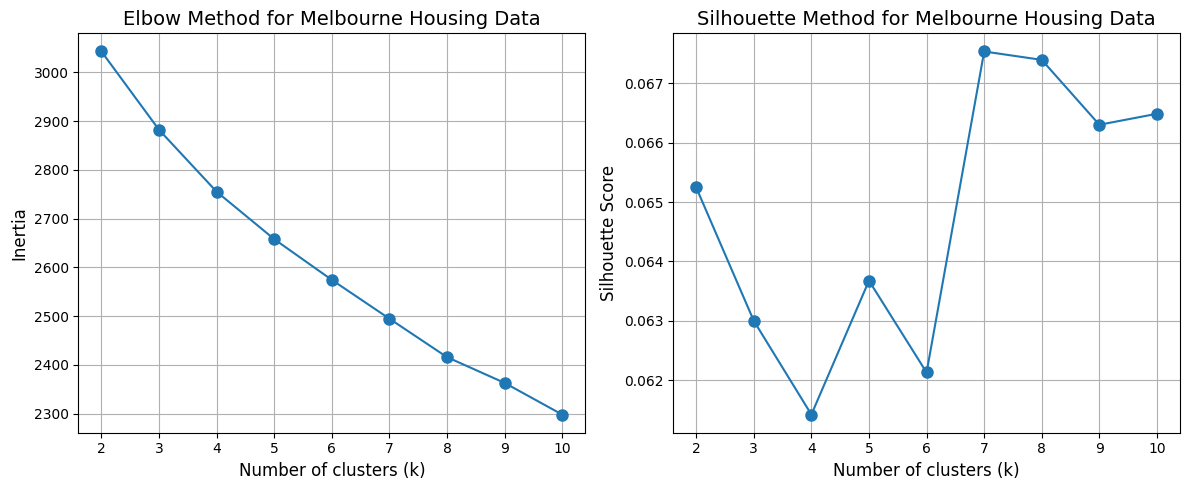

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, 'o-', markersize=8)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Melbourne Housing Data', fontsize=14)
plt.grid(True)
plt.xticks(k_values)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'o-', markersize=8)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Method for Melbourne Housing Data', fontsize=14)
plt.grid(True)
plt.xticks(k_values)

plt.tight_layout()
plt.show()

In [9]:
# Choose optimal k - highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters (k): {optimal_k}")

# Train final K-means model with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_train_pca)

# Predict clusters for training and test sets
train_clusters = kmeans.predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

# Evaluate model
train_silhouette = silhouette_score(X_train_pca, train_clusters)
test_silhouette = silhouette_score(X_test_pca, test_clusters)

print(f"\nTraining silhouette score: {train_silhouette:.4f}")
print(f"Test silhouette score: {test_silhouette:.4f}")


Optimal number of clusters (k): 7

Training silhouette score: 0.0675
Test silhouette score: 0.0211


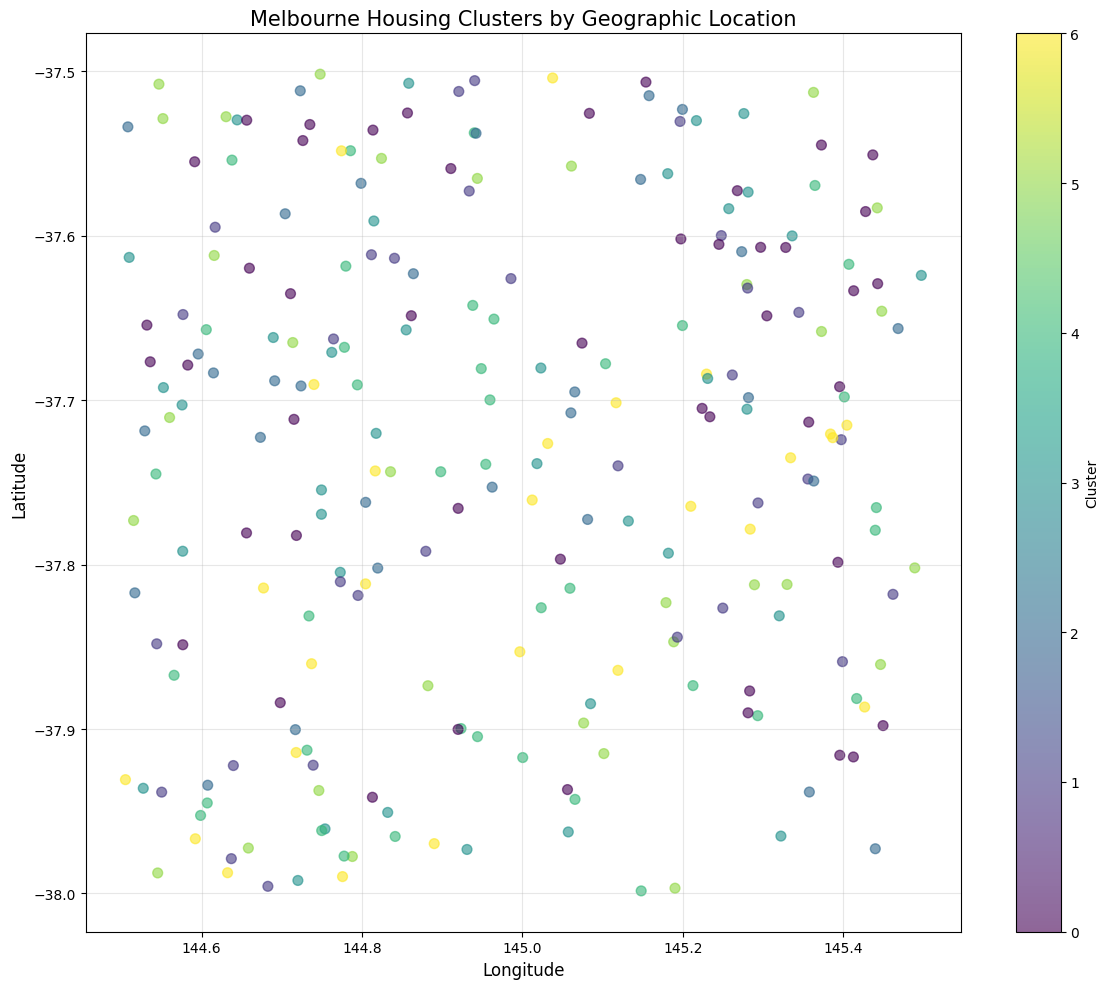

Note: Could not plot centroids in 2D PCA space due to dimension mismatch: X has 17 features, but PCA is expecting 23 features as input.
This is expected since the centroids exist in a different dimensional space.


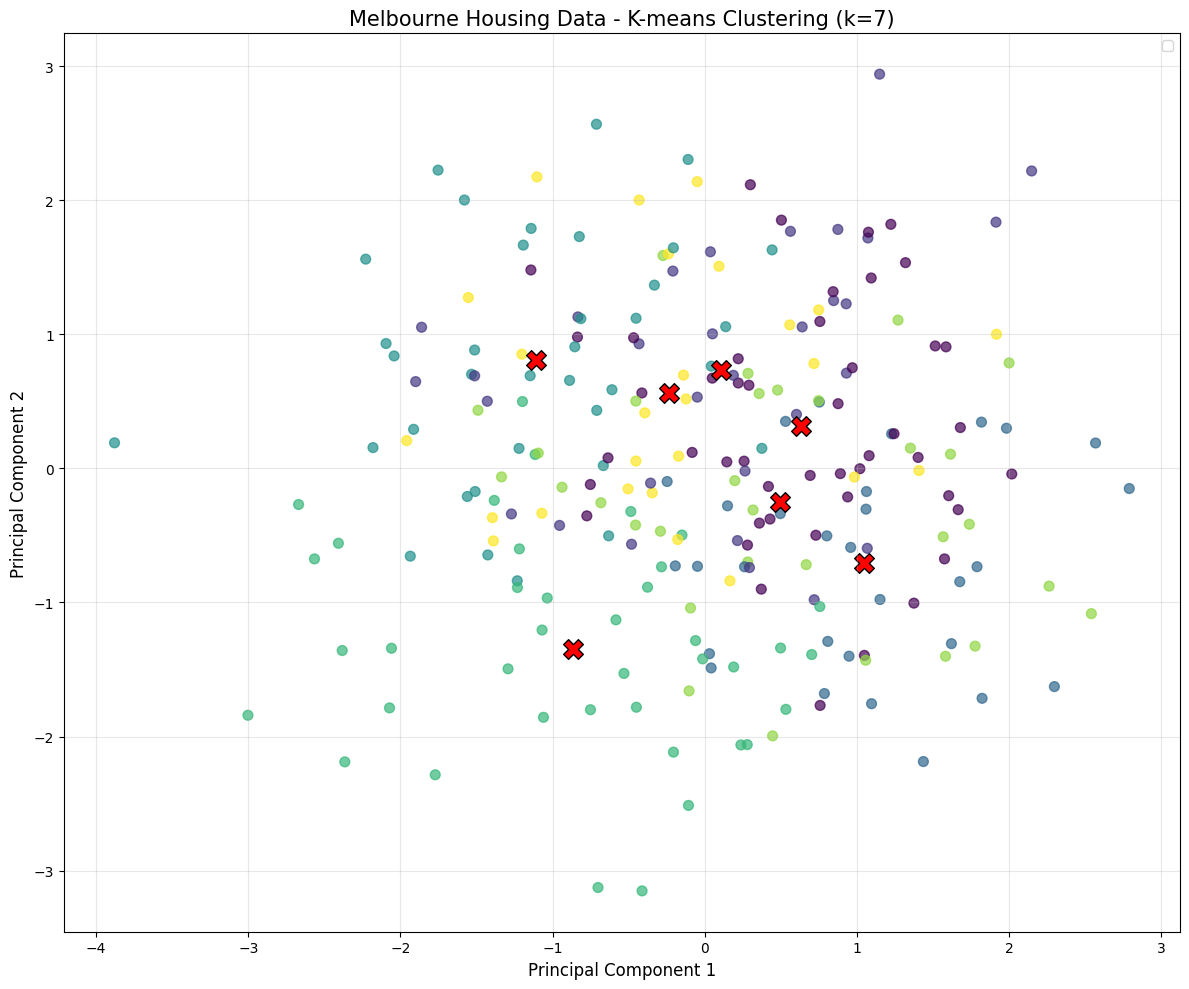

In [11]:
train_indices = df.index[:-len(X_test)]  
X_train_with_clusters = df.iloc[train_indices].copy()
X_train_with_clusters['Cluster'] = train_clusters

plt.figure(figsize=(12, 10))
plt.scatter(X_train_with_clusters['Longtitude'], X_train_with_clusters['Lattitude'], 
            c=train_clusters, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(label='Cluster')
plt.title('Melbourne Housing Clusters by Geographic Location', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=train_clusters, 
            cmap='viridis', s=50, alpha=0.7)

try:
    centroids_2d = pca_2d.transform(kmeans.cluster_centers_)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=200, marker='X', c='red', 
                edgecolor='black', label='Centroids')
except ValueError as e:
    print(f"Note: Could not plot centroids in 2D PCA space due to dimension mismatch: {e}")
    print("This is expected since the centroids exist in a different dimensional space.")
    for cluster_id in range(optimal_k):
        cluster_points = X_train_pca_2d[train_clusters == cluster_id]
        centroid_x = cluster_points[:, 0].mean()
        centroid_y = cluster_points[:, 1].mean()
        plt.scatter(centroid_x, centroid_y, s=200, marker='X', c='red', 
                    edgecolor='black')

plt.title(f'Melbourne Housing Data - K-means Clustering (k={optimal_k})', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


===== Cluster Analysis =====

Cluster Statistics:
              Price                  Rooms Bathroom Landsize BuildingArea  \
               mean        std count  mean     mean     mean         mean   
Cluster                                                                     
0        1298449.02  456662.36    47  3.17     2.17   479.72       169.50   
1        1251877.74  490560.59    31  2.97     2.03   568.71       164.10   
2        1036850.22  492948.28    30  2.67     2.17   593.82       173.98   
3        1260134.32  412041.52    36  3.11     1.86   577.88       176.80   
4        1246290.57  426550.91    39  3.18     2.00   532.70       166.43   
5        1173754.58  452483.18    31  3.16     1.97   546.49       179.39   
6         956728.73  548863.58    26  2.96     2.12   541.49       147.29   

        Distance YearBuilt  
            mean      mean  
Cluster                     
0          19.69   1959.23  
1          21.40   1958.07  
2          18.24   1966.93  
3   

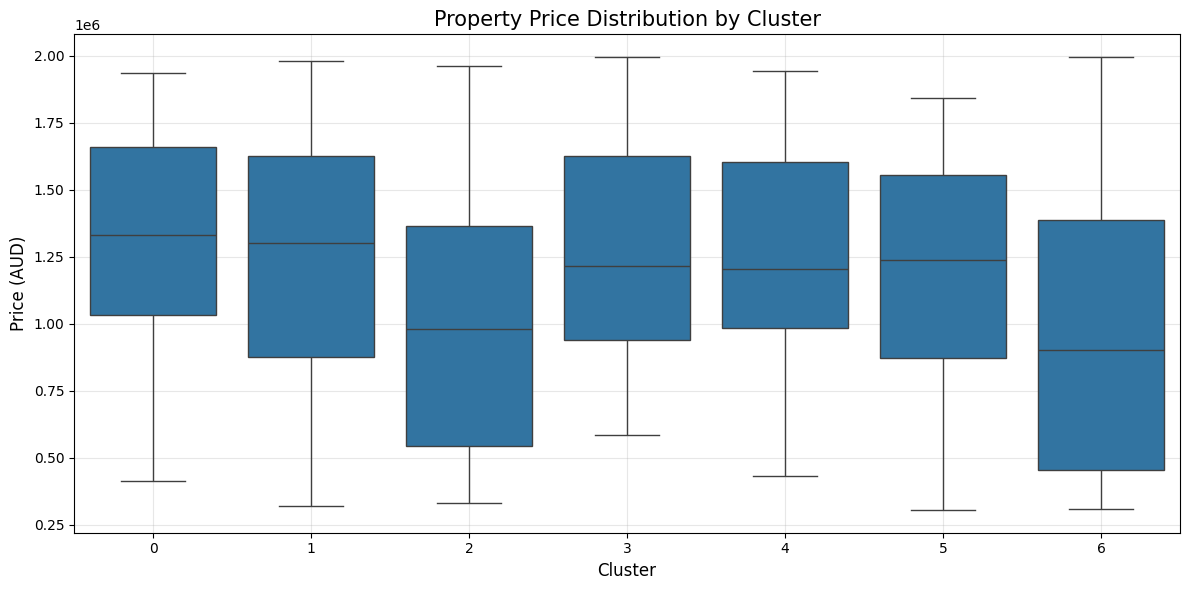

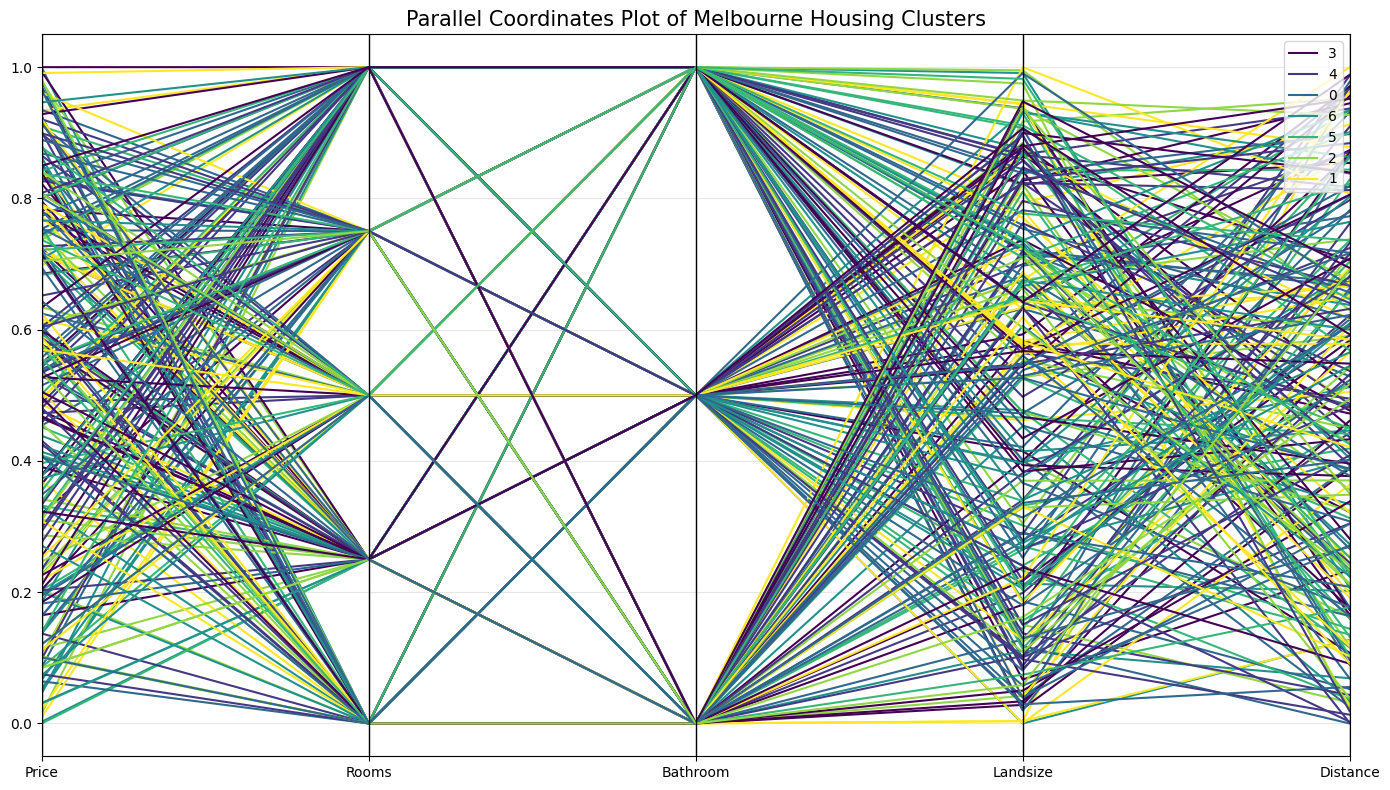

<Figure size 1200x600 with 0 Axes>

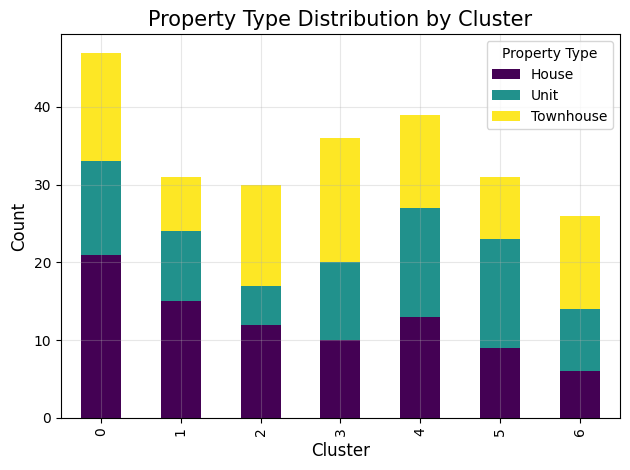


===== Conclusion =====
Successfully clustered Melbourne housing data into 7 groups
Silhouette score on test data: 0.0211


In [12]:
print("\n===== Cluster Analysis =====")

cluster_analysis = X_train_with_clusters.groupby('Cluster').agg({
    'Price': ['mean', 'std', 'count'],
    'Rooms': 'mean',
    'Bathroom': 'mean',
    'Landsize': 'mean',
    'BuildingArea': 'mean',
    'Distance': 'mean',
    'YearBuilt': 'mean'
}).round(2)

print("\nCluster Statistics:")
print(cluster_analysis)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Price', data=X_train_with_clusters)
plt.title('Property Price Distribution by Cluster', fontsize=15)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Price (AUD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

features_to_plot = ['Price', 'Rooms', 'Bathroom', 'Landsize', 'Distance']
features_df = X_train_with_clusters[features_to_plot + ['Cluster']].copy()

for feature in features_to_plot:
    features_df[feature] = (features_df[feature] - features_df[feature].min()) / \
                           (features_df[feature].max() - features_df[feature].min())

plt.figure(figsize=(14, 8))
pd.plotting.parallel_coordinates(features_df, 'Cluster', colormap='viridis')
plt.title('Parallel Coordinates Plot of Melbourne Housing Clusters', fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
property_type_counts = X_train_with_clusters.groupby(['Cluster', 'Type']).size().unstack().fillna(0)
property_type_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Property Type Distribution by Cluster', fontsize=15)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Property Type', labels=['House', 'Unit', 'Townhouse'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n===== Conclusion =====")
print(f"Successfully clustered Melbourne housing data into {optimal_k} groups")
print(f"Silhouette score on test data: {test_silhouette:.4f}")


In [13]:
print("\nCluster Interpretation:")
for cluster in range(optimal_k):
    cluster_data = X_train_with_clusters[X_train_with_clusters['Cluster'] == cluster]
    
    avg_price = cluster_data['Price'].mean()
    avg_rooms = cluster_data['Rooms'].mean()
    avg_distance = cluster_data['Distance'].mean()
    
    print(f"\nCluster {cluster}:")
    print(f"  - Properties: {len(cluster_data)} ({len(cluster_data)/len(X_train_with_clusters)*100:.1f}%)")
    print(f"  - Avg Price: ${avg_price:.2f}")
    print(f"  - Avg Rooms: {avg_rooms:.1f}")
    print(f"  - Avg Distance from CBD: {avg_distance:.1f} km")

    most_common_type = cluster_data['Type'].value_counts().idxmax()
    type_mapping = {'h': 'House', 'u': 'Unit', 't': 'Townhouse'}
    print(f"  - Most common property type: {type_mapping.get(most_common_type, most_common_type)}")
    
    most_common_region = cluster_data['Regionname'].value_counts().idxmax()
    print(f"  - Most common region: {most_common_region}")

print("\nNext steps could include:")
print("1. Using these clusters for targeted market analysis")
print("2. Building price prediction models for each cluster separately")
print("3. Creating a recommender system for property buyers based on cluster preferences")
print("4. Deepening the analysis with more complex clustering methods like DBSCAN")
print("5. Exploring temporal patterns in the clusters based on sale dates")


Cluster Interpretation:

Cluster 0:
  - Properties: 47 (19.6%)
  - Avg Price: $1298449.02
  - Avg Rooms: 3.2
  - Avg Distance from CBD: 19.7 km
  - Most common property type: House
  - Most common region: Southern Metropolitan

Cluster 1:
  - Properties: 31 (12.9%)
  - Avg Price: $1251877.74
  - Avg Rooms: 3.0
  - Avg Distance from CBD: 21.4 km
  - Most common property type: House
  - Most common region: Eastern Metropolitan

Cluster 2:
  - Properties: 30 (12.5%)
  - Avg Price: $1036850.22
  - Avg Rooms: 2.7
  - Avg Distance from CBD: 18.2 km
  - Most common property type: Unit
  - Most common region: Southern Metropolitan

Cluster 3:
  - Properties: 36 (15.0%)
  - Avg Price: $1260134.32
  - Avg Rooms: 3.1
  - Avg Distance from CBD: 22.9 km
  - Most common property type: Unit
  - Most common region: Eastern Metropolitan

Cluster 4:
  - Properties: 39 (16.2%)
  - Avg Price: $1246290.57
  - Avg Rooms: 3.2
  - Avg Distance from CBD: 22.6 km
  - Most common property type: Townhouse
  - Mo